In [39]:
#intervention in langraph using cust tools

In [38]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
llm=ChatGroq(model="gemma2-9b-it")

In [4]:
response=llm.invoke("what is gen ai")

In [5]:
response.content

"## Gen AI: Generating with Artificial Intelligence\n\nGen AI, short for **Generative Artificial Intelligence**, is a type of AI that focuses on **creating new content**.  \n\nThink of it as AI that doesn't just process and analyze existing data, but **generates entirely new outputs** based on learned patterns and information.\n\nHere's a breakdown:\n\n**What Gen AI can do:**\n\n* **Text:** Write stories, poems, articles, code, dialogue, and more.\n* **Images:** Create realistic images, artwork, and designs.\n* **Audio:** Compose music, generate sound effects, and synthesize speech.\n* **Video:** Produce short video clips and animations.\n* **Other:** 3D models, synthetic data, and even scientific discoveries.\n\n**How Gen AI works:**\n\nGen AI models are typically trained on massive datasets of existing content. They learn the underlying patterns and structures within this data, allowing them to generate new content that resembles the training material.\n\n**Popular Gen AI models:**\n

In [6]:
from langchain.tools import tool

In [7]:
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [8]:
from langchain_community.tools import TavilySearchResults

In [9]:
@tool
def search(query:str):
    """web search from the internet"""
    tavily=TavilySearchResults()
    response=tavily.invoke(query)
    return response

In [10]:
search.invoke("how to to become an Artificial intelligence and machine learning engineer")

[{'url': 'https://www.simplilearn.com/tutorials/artificial-intelligence-tutorial/how-to-become-an-ai-engineer',
  'content': "Find Post Graduate Program in AI and Machine Learning\nin these cities\nRecommended Resources\nTop 18 Artificial Intelligence (AI) Applications in 2024\nArtificial Intelligence Career Guide: A Comprehensive Playbook to Becoming an AI Expert\nAI Engineer Salary in 2024: US, India, Canada and More\nEmbark on a High-Growth AI/ML Career Path in 2024 with the UT Dallas AI/ML Bootcamp\nHow Does AI Work\nIntroduction to Artificial Intelligence: Having credentials in data science, deep learning, and machine learning may help you get a job and offer you a thorough grasp of essential subjects.\nResponsibilities of an AI Engineer\nAs an AI engineer or an ML engineer, you need to perform certain tasks, such as develop, test, and deploy AI models through programming algorithms like random forest, logistic regression, linear regression, and so on. The master's program consist

In [11]:
@tool
def multiply(first_num:int,second_num:int)->int:
    """multiply two integer number"""
    return first_num * second_num

In [12]:
multiply

StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000026A825DD4E0>)

In [13]:
multiply({'first_num':5,'second_num':10})

C:\Users\user\AppData\Local\Temp\ipykernel_41612\1011170761.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({'first_num':5,'second_num':10})


50

In [14]:
#create toolkit

In [15]:
tools=[search,multiply]

In [16]:
model_with_tools=llm.bind_tools(tools)

In [17]:
tool_mapping={tool.name:tool for tool in tools}

In [18]:
tool_mapping

{'search': StructuredTool(name='search', description='web search from the internet', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000026A822DB4C0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000026A825DD4E0>)}

In [19]:
#response=model_with_tools.invoke("what is gen ai")

In [20]:
response

AIMessage(content="## Gen AI: Generating with Artificial Intelligence\n\nGen AI, short for **Generative Artificial Intelligence**, is a type of AI that focuses on **creating new content**.  \n\nThink of it as AI that doesn't just process and analyze existing data, but **generates entirely new outputs** based on learned patterns and information.\n\nHere's a breakdown:\n\n**What Gen AI can do:**\n\n* **Text:** Write stories, poems, articles, code, dialogue, and more.\n* **Images:** Create realistic images, artwork, and designs.\n* **Audio:** Compose music, generate sound effects, and synthesize speech.\n* **Video:** Produce short video clips and animations.\n* **Other:** 3D models, synthetic data, and even scientific discoveries.\n\n**How Gen AI works:**\n\nGen AI models are typically trained on massive datasets of existing content. They learn the underlying patterns and structures within this data, allowing them to generate new content that resembles the training material.\n\n**Popular 

In [21]:
#tool_details=response.additional_kwargs.get('tool_calls',[])

In [22]:
import operator
from typing import Annotated
from langgraph.graph import END
from langgraph.graph.message import add_messages,StateGraph
from typing import TypedDict,Sequence
from langchain_core.messages import BaseMessage
import json

In [23]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]
    

In [24]:
def invoke_llm(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    return {"messages":[model_with_tools.invoke(question)]}

In [25]:
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].additional_kwargs.get("tool_calls",[])[0]

    if tool_details is None:
        raise Exception("no tool call is available")
    
    print(f"{tool_details.get("function").get("name")}")

    if tool_details.get("function").get("name")=="search":
        response=input(prompt=f"[y/n] continue with expensive service to y or n")
        if response=="n":
            raise Exception("web search discard")
    
    response=tool_mapping[tool_details.get("function").get("name")].invoke(json.loads(tool_details.get("function").get("arguments")))
    
    return {"messages":[response]}
    

In [26]:
def router(state:AgentState):
    tool_call=state["messages"][-1].additional_kwargs.get('tool_calls',[])
    print(tool_call)
    if len(tool_call):
        return "tool"
    else:
        return "end"

In [27]:
graph=StateGraph(AgentState)

In [28]:
graph.add_node("tools",invoke_tool)

In [29]:
graph.add_node("ai_assisstance",invoke_llm)

In [30]:
graph.add_conditional_edges(
                            "ai_assisstance",
                            router,
                            {
                                "tool":"tools",
                                "end":END,
                            })

In [31]:
graph.set_entry_point("ai_assisstance")

In [32]:
graph.add_edge("tools",END)

In [33]:
app=graph.compile()

In [34]:
from IPython.display import Image,display

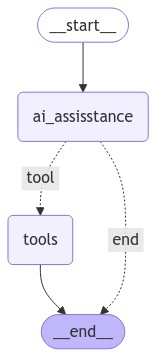

In [35]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [36]:
for s in app.stream({"messages":["what is gen ai"]}):
    print(list(s.values())[0])
    print("------")

[{'id': 'call_yexk', 'function': {'arguments': '{"query":"what is generative ai"}', 'name': 'search'}, 'type': 'function'}]
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yexk', 'function': {'arguments': '{"query":"what is generative ai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1069, 'total_tokens': 1152, 'completion_time': 0.150909091, 'prompt_time': 0.048629928, 'queue_time': 0.021205990999999993, 'total_time': 0.199539019}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6f2fbc54-907f-40ac-8443-f4a1abde9651-0', tool_calls=[{'name': 'search', 'args': {'query': 'what is generative ai'}, 'id': 'call_yexk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1069, 'output_tokens': 83, 'total_tokens': 1152})]}
------
search
{'messages': [[{'url': 'https://research.ibm.com/blog/what-is-generat

In [37]:
for s in app.stream({"messages":["what is the multiplication of 25 and 35"]}):
    print(list(s.values())[0])
    print("------")

[{'id': 'call_f4ns', 'function': {'arguments': '{"first_num":25,"second_num":35}', 'name': 'multiply'}, 'type': 'function'}]
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f4ns', 'function': {'arguments': '{"first_num":25,"second_num":35}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1077, 'total_tokens': 1170, 'completion_time': 0.169090909, 'prompt_time': 0.034227324, 'queue_time': 0.020740470999999996, 'total_time': 0.203318233}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-91f6822f-8b25-400a-8022-90f06063ef1d-0', tool_calls=[{'name': 'multiply', 'args': {'first_num': 25, 'second_num': 35}, 'id': 'call_f4ns', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1077, 'output_tokens': 93, 'total_tokens': 1170})]}
------
multiply
{'messages': [875]}
------
